In [3]:
import numpy as np 
import pandas as pd 
import os 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder , LabelEncoder
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset , DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , accuracy_score , classification_report,silhouette_score , precision_score ,f1_score ,recall_score


In [4]:
train_df_path='/kaggle/input/isic-2024-challenge/train-metadata.csv'
test_df_path='/kaggle/input/isic-2024-challenge/test-metadata.csv'

train_df =pd.read_csv(train_df_path)
test_df =pd.read_csv(test_df_path)

train_df.head()

/tmp/ipykernel_36/3919548570.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df =pd.read_csv(train_df_path)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [5]:
missing_values=train_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_d

In [6]:
columns_to_remove = ['lesion_id' , 'iddx_2' , 'iddx_3' , 'iddx_4' , 'iddx_5' , 'mel_mitotic_index' , 'mel_thick_mm']

clean_df = train_df.drop(columns=columns_to_remove , errors='ignore')

train_df_cleaned_nonull = clean_df.dropna()


In [7]:
train_df_cleaned_nonull['target'].value_counts()

target
0    381533
1       381
Name: count, dtype: int64

In [8]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = train_df_cleaned_nonull[train_df_cleaned_nonull['target'] == 0]
minority_class = train_df_cleaned_nonull[train_df_cleaned_nonull['target'] == 1]

# Downsample majority class to the size of the minority class
majority_class_downsampled = resample(majority_class, 
                                      replace=False, 
                                      n_samples=len(minority_class),  # Downsample to the size of the minority class
                                      random_state=42)

# Combine downsampled majority class with the minority class
train_df_balanced = pd.concat([majority_class_downsampled, minority_class])

# Print shape and class distribution
print("Shape After Balancing classes:", train_df_balanced.shape)
print("Class Distribution after balancing:\n", train_df_balanced['target'].value_counts())


Shape After Balancing classes: (762, 48)
Class Distribution after balancing:
 target
0    381
1    381
Name: count, dtype: int64


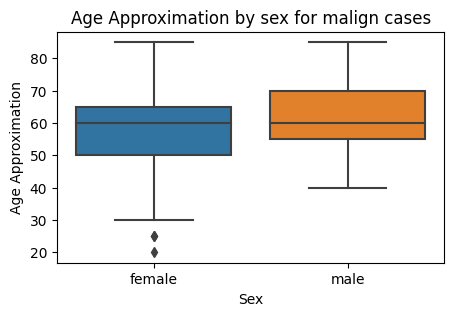

In [9]:
filtered_df = train_df_balanced[train_df_balanced['target']==1]

#create plot 
plt.figure(figsize=(5 , 3))
sns.boxplot(x='sex' , y='age_approx' , data=filtered_df)
plt.title('Age Approximation by sex for malign cases')
plt.xlabel('Sex')
plt.ylabel('Age Approximation')
plt.show()

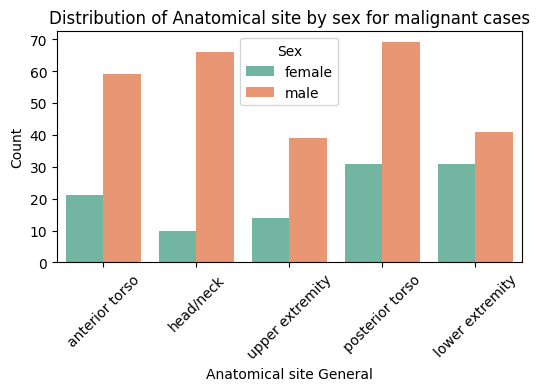

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.countplot(x='anatom_site_general', hue='sex', data=filtered_df, palette='Set2')  # Fixed 'palette' typo
plt.title('Distribution of Anatomical site by sex for malignant cases')
plt.xlabel('Anatomical site General')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sex')  # Title for legend
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


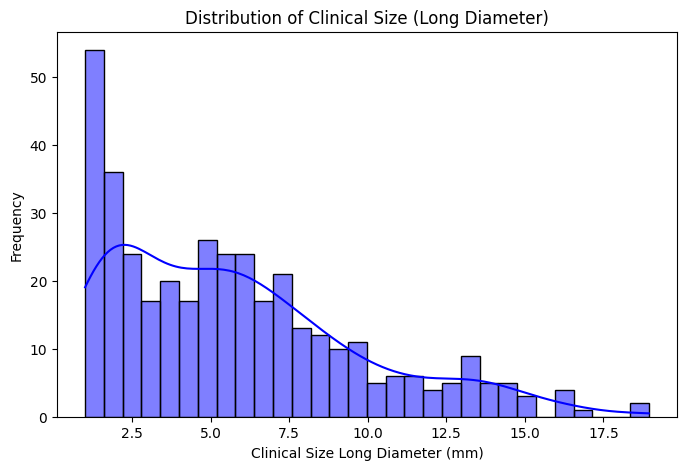

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))  # Set the figure size
sns.histplot(filtered_df['clin_size_long_diam_mm'], bins=30, kde=True, color='blue')  # Create the histogram with KDE curve
plt.title('Distribution of Clinical Size (Long Diameter)')  # Title of the plot
plt.xlabel('Clinical Size Long Diameter (mm)')  # Label for x-axis
plt.ylabel('Frequency')  # Label for y-axis
plt.show()


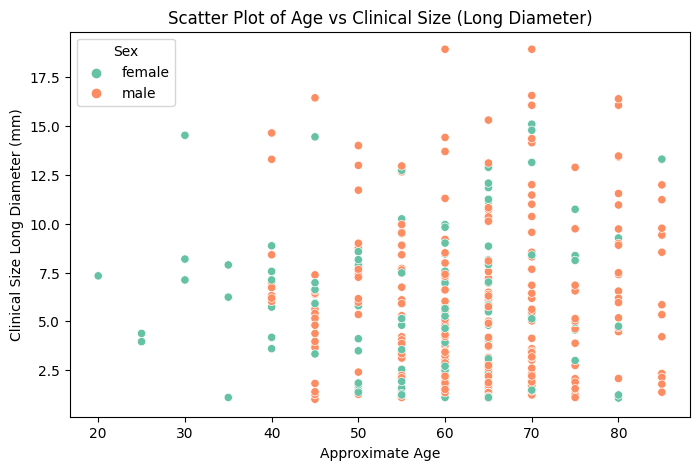

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))  # Set the figure size
sns.scatterplot(x='age_approx', y='clin_size_long_diam_mm', data=filtered_df, hue='sex', palette='Set2')  # Create scatter plot
plt.title('Scatter Plot of Age vs Clinical Size (Long Diameter)')  # Title of the plot
plt.xlabel('Approximate Age')  # Label for x-axis
plt.ylabel('Clinical Size Long Diameter (mm)')  # Label for y-axis
plt.legend(title='Sex')  # Legend with title
plt.show()


In [13]:
train_df_balanced['sex']=train_df_balanced['sex'].map({'male':1 , 'female':0})

In [14]:
train_df_balanced['anatom_site_general'].value_counts()

anatom_site_general
posterior torso    212
lower extremity    179
anterior torso     172
upper extremity    110
head/neck           89
Name: count, dtype: int64

In [15]:
anatom_site_mapping={
    'posterior torso':1,
    'lower extremity':2,
    'anterior torso':3,
    'upper extremity':4,
    'head/neck':5
}
train_df_balanced['anatom_site_general']=train_df_balanced['anatom_site_general'].apply(
lambda x:anatom_site_mapping.get(x , 0))

In [16]:
train_df_balanced['tbp_lv_location_simple'].value_counts()

tbp_lv_location_simple
Torso Back     212
Torso Front    172
Left Leg        99
Head & Neck     89
Right Leg       80
Left Arm        57
Right Arm       53
Name: count, dtype: int64

In [17]:
# Define the mapping dictionary
location_mapping = {
    'Torso Back': 0,
    'Torso Front': 1,
    'Left Leg': 2,
    'Head & Neck': 3,
    'Right Leg': 4,
    'Left Arm': 5,
    'Right Arm': 6
}

# Apply the mapping to the column
train_df_balanced['tbp_lv_location_simple_encoded'] = train_df_balanced['tbp_lv_location_simple'].map(location_mapping)

# Check the first few rows to verify
print(train_df_balanced[['tbp_lv_location_simple', 'tbp_lv_location_simple_encoded']].head())


       tbp_lv_location_simple  tbp_lv_location_simple_encoded
44730              Torso Back                               0
362429               Left Leg                               2
17389              Torso Back                               0
367815             Torso Back                               0
192982               Left Leg                               2


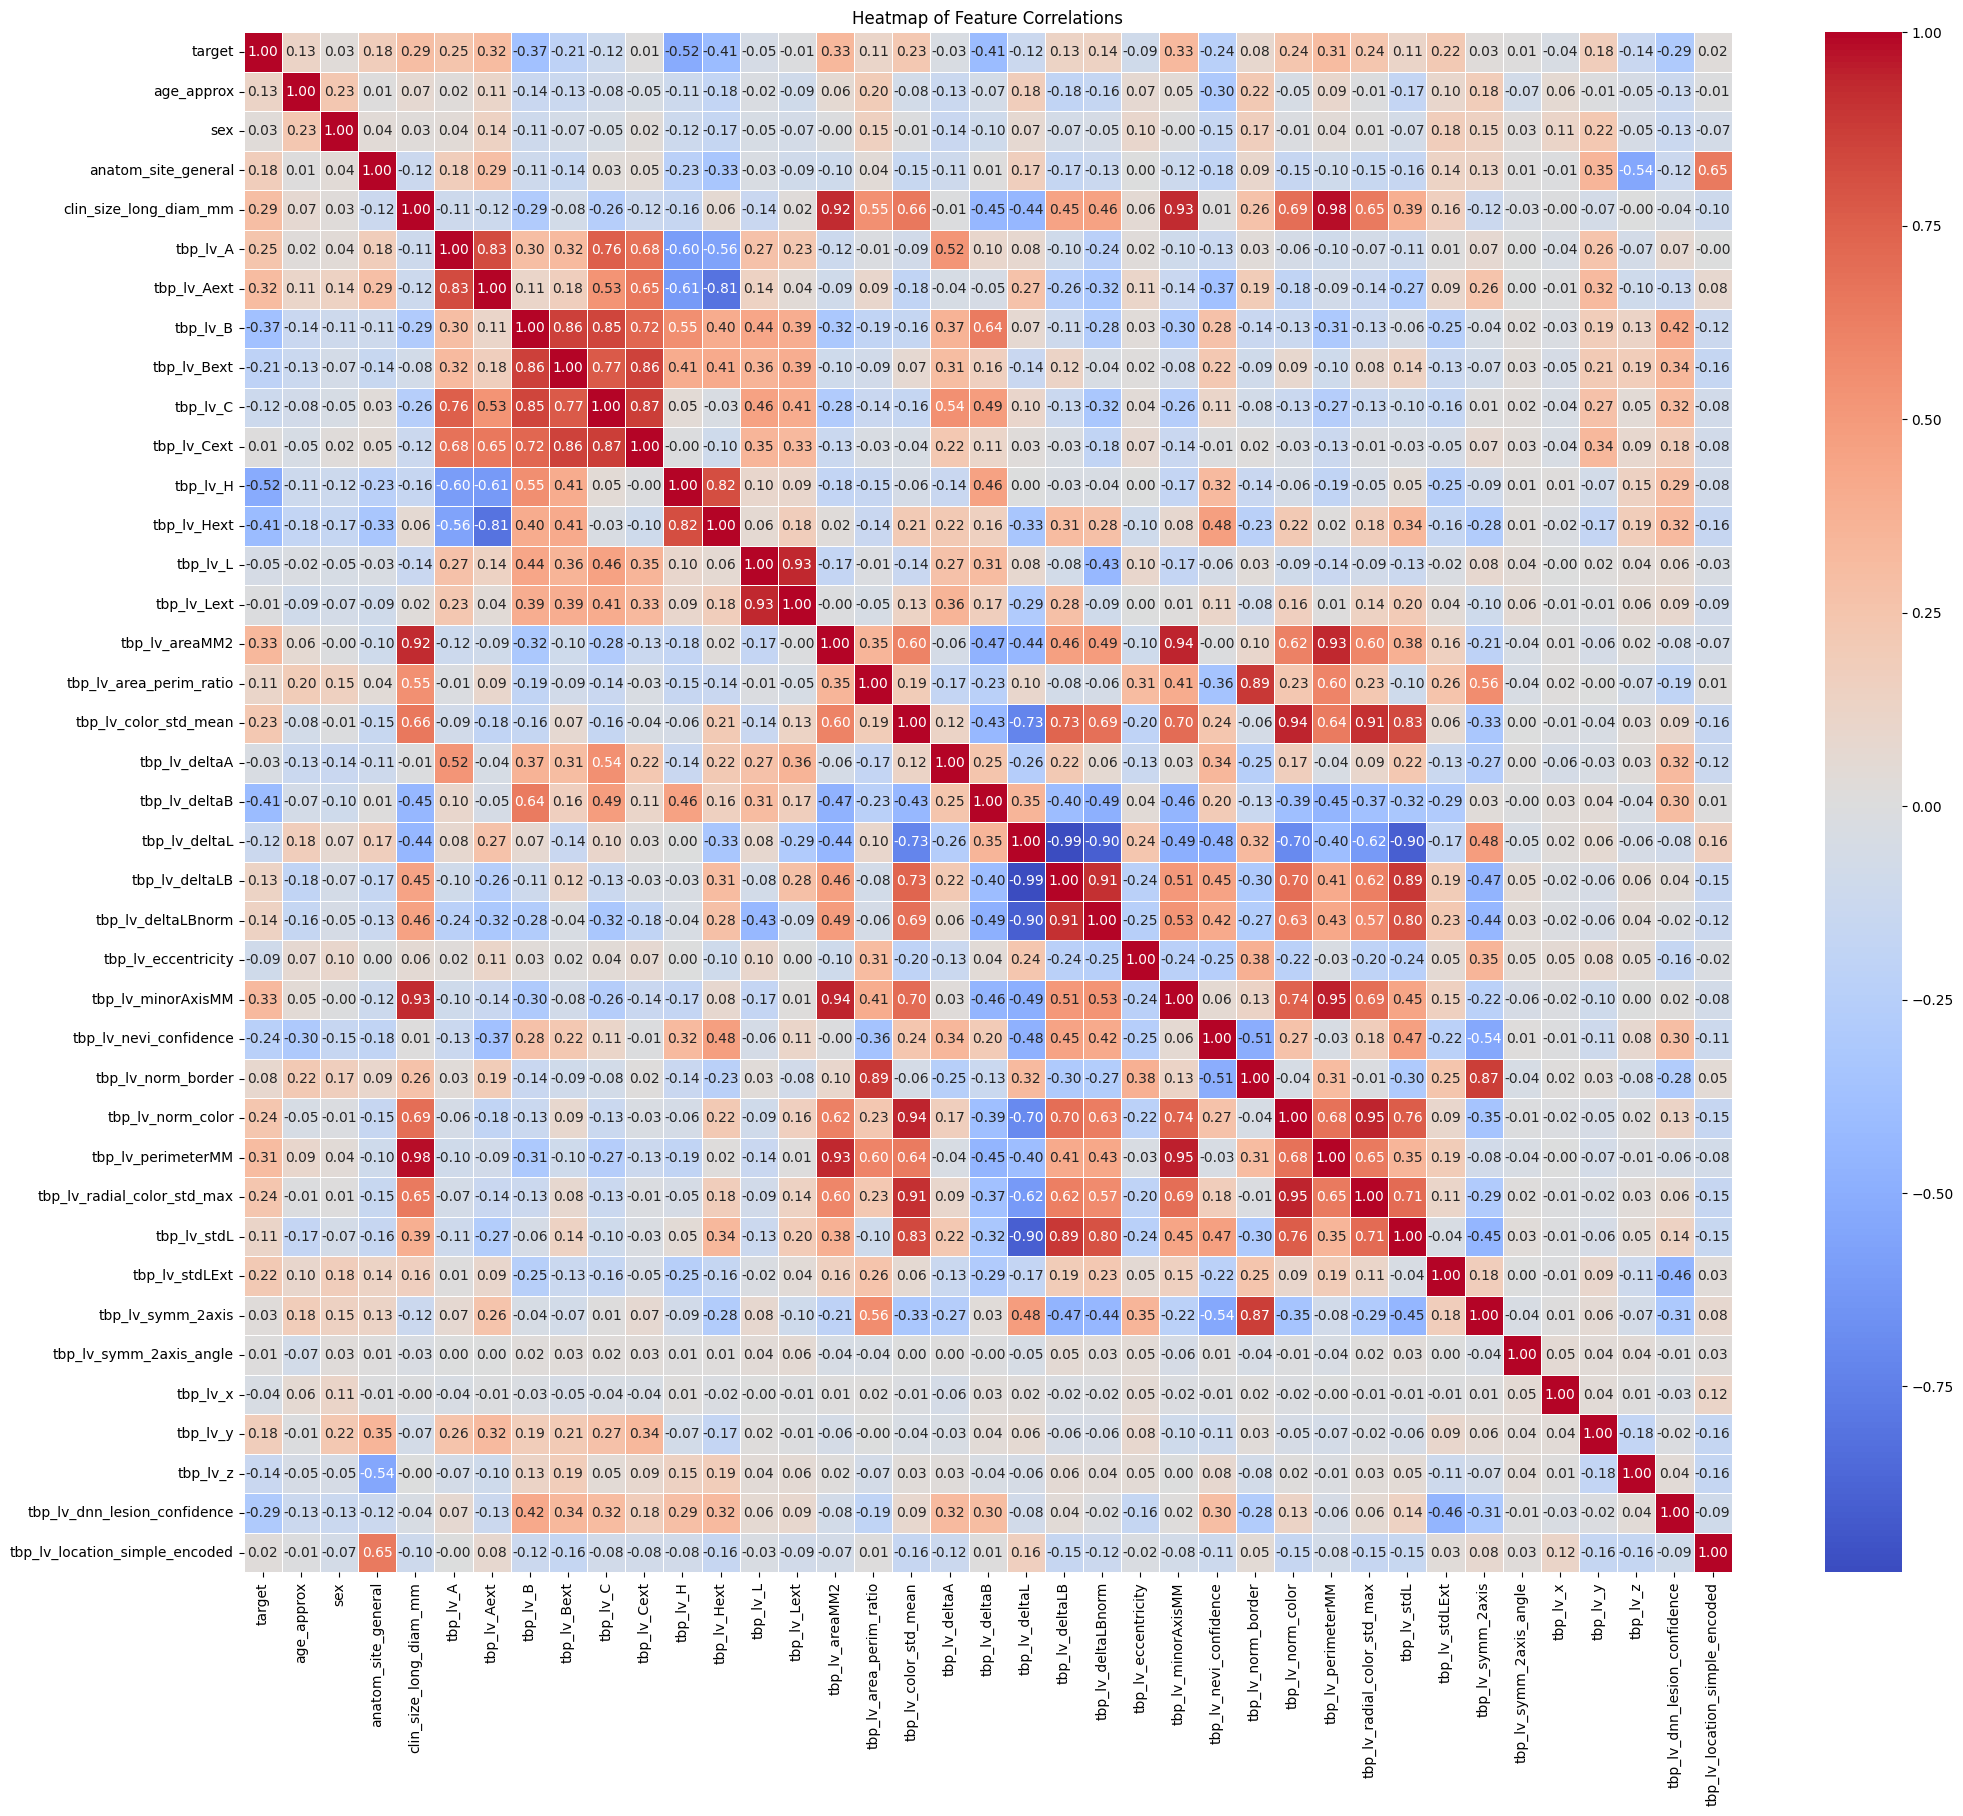

In [18]:
# Drop columns that are non-numeric
data_for_heatmap = train_df_balanced.drop(columns=['isic_id', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license', 'iddx_full', 'iddx_1'])

# Keep only numeric columns
data_for_heatmap_numeric = data_for_heatmap.select_dtypes(include=['float64', 'int64'])

# Plot the heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(data_for_heatmap_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()


In [19]:
# Define X (features) and y (target variable)
x = train_df_balanced.drop(columns=['isic_id', 'target', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license', 'iddx_full', 'iddx_1', 'tbp_lv_dnn_lesion_confidence'])

y = train_df_balanced['target']


In [20]:
x_encoded = pd.get_dummies(x, drop_first=True)


In [21]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x_encoded)

In [22]:
x_tensor = torch.tensor(x_scaled , dtype=torch.float32)
y_tensor = torch.tensor(y.values , dtype=torch.float32).view(-1 , 1)

In [23]:
x_train , x_val , y_train , y_val = train_test_split(x_tensor , y_tensor , test_size=0.2 , random_state=42)


In [24]:
#Create Dataloader
batch_size =64
train_dataset = TensorDataset(x_train , y_train)
val_dataset = TensorDataset(x_train , y_train)
train_loader = DataLoader(train_dataset , batch_size=batch_size , shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=batch_size , shuffle=False)

In [25]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation to get probabilities

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model
input_dim = x_tensor.shape[1]
model = SimpleNN(input_dim)

# Define loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop

In [26]:
num_epochs = 20  # Fixed typo from 'ephocs' to 'epochs'
for epoch in range(num_epochs):  # Fixed typo from 'ephocs' to 'epoch'
    model.train()  # Set model to training mode
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation during evaluation
        val_loss = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

        val_loss /= len(val_loader)  # Calculate average validation loss

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/20, Validation Loss: 0.6670
Epoch 2/20, Validation Loss: 0.6278
Epoch 3/20, Validation Loss: 0.5764
Epoch 4/20, Validation Loss: 0.5117
Epoch 5/20, Validation Loss: 0.4476
Epoch 6/20, Validation Loss: 0.3972
Epoch 7/20, Validation Loss: 0.3638
Epoch 8/20, Validation Loss: 0.3407
Epoch 9/20, Validation Loss: 0.3228
Epoch 10/20, Validation Loss: 0.3081
Epoch 11/20, Validation Loss: 0.2965
Epoch 12/20, Validation Loss: 0.2855
Epoch 13/20, Validation Loss: 0.2760
Epoch 14/20, Validation Loss: 0.2672
Epoch 15/20, Validation Loss: 0.2590
Epoch 16/20, Validation Loss: 0.2516
Epoch 17/20, Validation Loss: 0.2426
Epoch 18/20, Validation Loss: 0.2351
Epoch 19/20, Validation Loss: 0.2287
Epoch 20/20, Validation Loss: 0.2204


In [27]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Set model to evaluation mode
model.eval()

# Disable gradient calculations for evaluation
with torch.no_grad():
    y_true = []
    y_pred = []

    # Iterate over validation batches
    for X_batch, y_batch in val_loader:
        # Forward pass
        outputs = model(X_batch)

        # Convert predicted probabilities to binary predictions (threshold of 0.5)
        predictions = (outputs > 0.5).float()

        # Append true and predicted labels to lists
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

# Convert lists to NumPy arrays for metrics calculations
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# Print evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)

Evaluation Metrics:
Accuracy: 0.9359605911330049
Precision: 0.9255663430420712
Recall: 0.9470198675496688
F1-score: 0.9361702127659574
ROC AUC: 0.9360506503872122


In [28]:
test_df.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [29]:
test_df_cleaned=test_df.drop(columns=columns_to_remove , errors='ignore')

In [34]:
# Define the mapping for 'tbp_lv_location'
tbp_lv_location_mapping = {
    'Torso Back Top Third': 1,
    'Torso Front': 2,
    'Left Leg': 3,
    'Head & Neck': 4,
    'Right Leg': 5,
    'Left Arm': 6,
    'Right Arm': 7,
    # Add other mappings as needed
}

# Apply the mapping
test_df_cleaned['tbp_lv_location'] = test_df_cleaned['tbp_lv_location'].apply(
    lambda x: tbp_lv_location_mapping.get(x, 0)  # Use 0 as a default value for missing mappings
)


In [36]:
#encode Gender
test_df_cleaned['sex'] = test_df_cleaned['sex'].map({'male': 1, 'female': 0})
#encode anatom_general
test_df_cleaned['anatom_site_general'] = test_df_cleaned['anatom_site_general'].apply(
    lambda x: anatom_site_mapping.get(x, 0)
)


In [38]:
# Drop the specified columns from test_metadata_cleaned
X_test = test_df_cleaned.drop(columns=['isic_id', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license'])

In [45]:
import numpy as np
import torch

# Check for missing values and either drop or fill them
X_test_cleaned = X_test.fillna(0)  # Replace NaN with 0, or you can use another strategy like .fillna(X_test.mean())

# Check for non-numeric columns and convert them to numeric if necessary
X_test_cleaned = X_test_cleaned.apply(pd.to_numeric, errors='coerce')  # Force non-numeric columns to NaN

# Refill or drop NaNs that might have appeared after converting to numeric
X_test_cleaned = X_test_cleaned.fillna(0)  # Fill NaN with 0 again

# Convert the cleaned DataFrame to a NumPy array
X_test_array = X_test_cleaned.values

# Now convert the NumPy array to a PyTorch tensor (dtype=torch.float32 for model compatibility)
x_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)

# If using a GPU (optional):
# x_test_tensor = x_test_tensor.cuda()

print(x_test_tensor.shape)  # Check the shape of your tensor


torch.Size([3, 38])


In [48]:
# Update the input_dim in your model to match the number of features in the dataset (38 in this case)
input_dim = 38  # Adjust this based on your test data
model = SimpleNN(input_dim)


In [49]:
print(x_test_tensor.shape)  # Ensure this is (N, input_dim) where input_dim matches your model's expectation
print(model.fc1.weight.shape)  # Ensure the first layer of the model expects input_dim features


torch.Size([3, 38])
torch.Size([64, 38])


In [50]:
import torch
import pandas as pd

# Assuming you have defined your model, X_test_tensor, and test_metadata

# Set model to evaluation mode
model.eval()

# Disable gradient calculations for inference
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(x_test_tensor)

    # Convert predicted probabilities to binary labels (threshold of 0.5)
    predicted_labels = (predictions > 0.5).float().numpy()


In [52]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'isic_id': test_df['isic_id'],  # Assuming 'isic_id' is the unique identifier in test data
    'target': predicted_labels.flatten()  # Flatten to match the format
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)